In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
from random import randint
from PIL import Image
import torch.optim as optim
import time
import QuickNAT as QN
import torch.nn as nn
from livelossplot import PlotLosses

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


In [3]:
for sub_idx in range(330):
    T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
    T1s_dir = '/home/xiaoyu/MRIdata/T1w/sagittal/sub{}'.format(sub_idx)
    T1c_dir = '/home/xiaoyu/MRIdata/T1w/coronal/sub{}'.format(sub_idx)
    
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
    parc5s_dir = '/home/xiaoyu/MRIdata/parc_5/sagittal/sub{}'.format(sub_idx)
    parc5c_dir = '/home/xiaoyu/MRIdata/parc_5/coronal/sub{}'.format(sub_idx)
    
    T1a_list = os.listdir(T1a_dir)
    T1s_list = os.listdir(T1s_dir)
    T1c_list = os.listdir(T1c_dir)
    
    parc5a_list = os.listdir(parc5a_dir)
    parc5s_list = os.listdir(parc5s_dir)
    parc5c_list = os.listdir(parc5c_dir)
    
    if sub_idx == 0: # set sub0 as test set.
        print('\nT1w Axial slices num:',len(T1a_list))
        print('T1w Sagittal slices num:',len(T1s_list))
        print('T1w Coronal slices num:',len(T1c_list))

        print('\nParc5 Axial slices num:',len(parc5a_list))
        print('Parc5 Sagittal slices num:',len(parc5s_list))
        print('Parc5 Coronal slices num:',len(parc5c_list))
        continue



T1w Axial slices num: 202
T1w Sagittal slices num: 217
T1w Coronal slices num: 182

Parc5 Axial slices num: 182
Parc5 Sagittal slices num: 217
Parc5 Coronal slices num: 182


In [5]:
# axial plane
for i in range(len(T1a_list)):
    T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
    T1a_str = T1a_list[i]
    parc5a_str = parc5a_list[i]
    T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
    parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
    
    print('Image array data type: ', T1a_arr.dtype)
    print('Mask array data type: ', parc5a_arr.dtype)
    
    # make 2 tensors from the numpy array for image and mask respectively
    T1a_tensor = torch.from_numpy(T1a_arr)
    parc5a_tensor = torch.from_numpy(parc5a_arr)
    
    # observe the data size of the image and mask
    print('\nImage data size: ', T1a_tensor.size())
    print('Mask data size:', parc5a_tensor.size())
    
    print(parc5a_tensor[4])
    
    if i ==0:
        break    

Image array data type:  uint8
Mask array data type:  uint8

Image data size:  torch.Size([182, 217])
Mask data size: torch.Size([182, 217])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], dtype=torch.uint8)


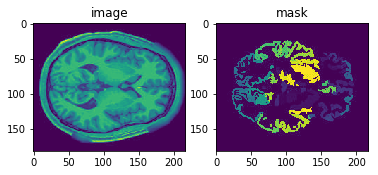

In [5]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()
    
# test the function
show_mask(T1a_arr, parc5a_arr)

In [6]:
colors = torch.tensor([])
for i in range(len(T1a_list)):
    
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
   
    parc5a_str = parc5a_list[i]
   
    parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
    
    parc5a_tensor = torch.from_numpy(parc5a_arr)
    
    unique_color = torch.unique(parc5a_tensor).type(torch.FloatTensor)
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)
print(colors.dtype)
print(colors.size())

tensor([  0.,  10.,   6.,  12.,   5.,   2.,   3.,   7.,  15.,  19.,  25., 181.,
        199.,  22.,   8.,   1.,  13.,  16., 174., 182., 172., 167., 189., 162.,
        193., 176., 196., 178., 187., 201., 194., 175.,   4.,  26.,  14., 184.,
        190., 171., 185., 225., 186., 197., 177., 191.,   9.,  24., 203., 216.,
        213.,  11., 163., 188., 166., 200., 168., 214., 202., 183., 179., 219.,
        235., 221., 170., 159., 198., 180.,  27., 192., 195., 215., 204., 205.,
        228., 222., 157., 169., 208., 223., 206., 210., 207., 212., 211., 226.,
         20., 173., 220.,  18., 227., 231., 224., 165., 209., 217., 152.,  17.,
        164.,  32., 234., 230., 218., 232.,  21., 239.,  29.,  23., 229., 160.,
        233., 245., 241., 150.,  28., 237., 122., 114.,  34.,  30.,  42.,  40.,
        101., 121.,  89., 112., 129., 238., 243.,  50.,  38.,  36.,  31.,  37.,
         33.,  46.,  43.,  45., 116., 113., 118., 117., 236.,  49.,  35.,  41.,
        107.,  80., 111., 109., 120., 10

In [7]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, T1a_dir, parc5a_dir, transform=None):
        """
        Args:
            T1a_dir (string): Directory with T1w image in axial plane
            transform (callable): Optional transform to be applied on a sample
            parc5a_dir (string): Directory with parcellation scale 5 in axial plane
        """
        self.T1a_dir = T1a_dir
        self.transform = transform
        self.parc5a_dir = parc5a_dir
        
    def __len__(self):
        T1a_list = os.listdir(self.T1a_dir)
        return len(T1a_list)
    
    
    def __getitem__(self, idx):
        T1a_list = os.listdir(T1a_dir)
        parc5a_list = os.listdir(parc5a_dir)
        
        T1a_str = T1a_list[idx]
        
        T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
        T1a_tensor = torch.from_numpy(T1a_arr)
        
        compose_T1 = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.Resize((128,128),interpolation=Image.NEAREST),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        T1a_tensor = torch.unsqueeze(T1a_tensor, dim = 0)
        T1a_tensor = compose_T1(T1a_tensor)
              
        parc5a_str = parc5a_list[idx]
    
        parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
        parc5a_tensor = torch.from_numpy(parc5a_arr)
        
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((128,128),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        parc5a_tensor = torch.unsqueeze(parc5a_tensor, dim = 0)
        parc5a_tensor = compose(parc5a_tensor)
        parc5a_tensor = parc5a_tensor.squeeze()
        
        parc5a_tensor = torch.round(parc5a_tensor / 0.0039).byte()
      
        sample = {'T1a':T1a_tensor, 'parc5a':parc5a_tensor}
        
        if self.transform:
            T1a = self.transform(T1a_tensor)
            sample = {'T1a':T1a, 'parc5a':parc5a}
            
        return sample

In [8]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
print('Total image number: {}'.format(len(train_data)))
colors = torch.tensor([])

for i in range(len(train_data)):
    sample = train_data[i]
    mask = sample['parc5a']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)

Total image number: 182
tensor([ 52., 163., 161., 159.,   0.,  10.,   5.,   6.,   3.,   7.,  19., 182.,
         15.,   2.,   8.,   1.,  26.,  14.,   4., 191., 172., 177., 200., 179.,
        186., 226., 187., 178., 192.,  24., 217.,  12.,   9.,  11., 164., 185.,
        189., 167., 201., 175., 173., 184., 190., 197., 183., 202., 222., 194.,
         25., 181., 180., 158., 188., 170., 168., 176., 224., 211., 215., 208.,
        212., 227.,  20., 174., 203., 209., 199., 214., 204.,  13., 221., 205.,
         18.,  22., 213., 193., 228., 153.,  16., 196., 220., 207., 235., 231.,
        219., 206., 169., 195.,  21., 218., 240., 216.,  29., 210., 229., 225.,
        223., 246., 166., 198., 171., 151., 238.,  23., 102.,  89., 113., 239.,
        244.,  34.,  38.,  36.,  33.,  46.,  50.,  45., 122., 117., 114., 119.,
        234., 237.,  49.,  30.,  28.,  32.,  41., 109., 124.,  92., 110., 123.,
        100., 236.,  40.,  96., 129.,  88., 121., 118.,  95., 116.,  35., 105.,
        162.,  1

In [9]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
print('Total T1a image number: {}'.format(len(train_data)))

maximum = torch.tensor([0],dtype=torch.float32)
minimum = torch.tensor([0],dtype=torch.float32)

for i in range(len(train_data)):
    sample = train_data[i]
    T1a = sample['T1a']
    parc5a = sample['parc5a']
        
    maxi = torch.max(T1a)
    mini = torch.min(T1a)

    if maximum < maxi:
        maximum = torch.max(T1a)
    if minimum > mini:
        minimum = torch.min(T1a)
 
print(maximum)
print(minimum)

Total T1a image number: 182
tensor(0.7882)
tensor(-1.)


T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.2863)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


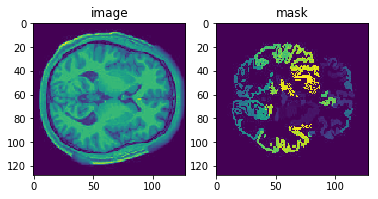

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.6784)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(20, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


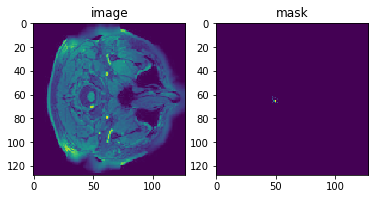

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5059)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(237, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


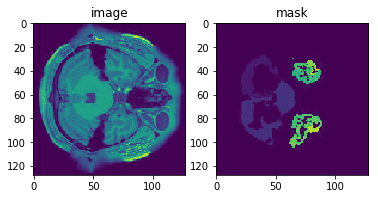

In [10]:
for i in range(len(train_data)):
    sample = train_data[i]
    T1a = sample['T1a']
    parc5a = sample['parc5a']
    
    print('T1a info:')
    print(T1a.size())
    print(T1a.dtype)
    print(torch.max(T1a))
    print(torch.min(T1a))
    
    print('\n parc5a info:')
    print(parc5a.dtype)
    print(parc5a.size())
    print(torch.max(parc5a))
    print(torch.min(parc5a))
    print(type(T1a))
    print('\nVisualization:')
    show_mask(T1a.squeeze(), parc5a)
    if i == 2:  
        break

In [11]:
dataloader = DataLoader(train_data, batch_size = 5, shuffle = True, num_workers = 4)

In [12]:
print(len(dataloader))

37


In [13]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['T1a'].size())
    print(sample_batched['parc5a'].size())
    if i_batch ==0:
        break

torch.Size([5, 1, 128, 128])
torch.Size([5, 128, 128])


In [14]:
# input channel is 3, output channel is 1
model = QN.QuickNAT(1,64,256)
print(model)
model_params = list(model.parameters())

nb_param=0
for param in model.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

QuickNAT(
  (encoder): Encoder(
    (conv_in): DenseBlock(
      (block1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (block2): Sequential(
        (0): Conv2d(65, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (outconv): Conv2d(129, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (down1): down(
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): DenseBlock(
        (block1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters

In [15]:
bs=5
x=torch.rand(bs,1,128,128)
y = model(x)
print(y.size())

torch.Size([5, 256, 128, 128])


In [16]:
model = model.to(device)

In [17]:
criterion = nn.NLLLoss()

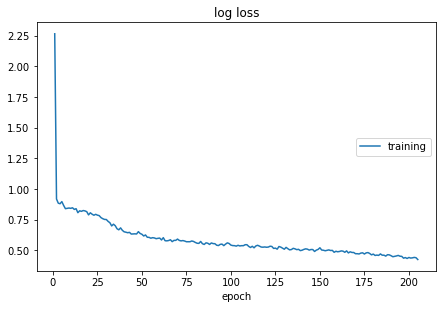

log loss:
training   (min:    0.425, max:    2.266, cur:    0.425)


In [ ]:
optimizer = optim.Adam(model.parameters() ,lr=0.001)
liveloss = PlotLosses()

start=time.time()
for epoch in range(1,500):
   
    logs = {}

    # define the running loss
    running_loss = 0
    running_error = 0
    num_batches=0
      
    for i_batch, sample_batched in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['T1a'], sample_batched['parc5a']
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = model(inputs)
      
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
    
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )
    
    logs['log loss'] = total_loss
            
    liveloss.update(logs)
    liveloss.draw()

       
print('Finish Training')

In [ ]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)

In [ ]:
sample=train_data[6]
img = sample['T1a']
mask = sample['parc5a']

show_mask(img.squeeze(), mask)

img = img.unsqueeze(dim = 0)

img = img.to(device)


# feed it to network
scores =  model(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)
print(scores.size())
scores = torch.exp(scores)
print(torch.max(scores))
print(torch.min(scores))
a,b = torch.max(scores,dim=2)
plt.imshow(b)
